# Novel applications of Argovis

Argovis' focus on search and indexing of Earth system data makes it especially well suited to a number of cross-referencing, filtration and summary tasks. While plots in this section could in principle be built from any data service providing this data, Argovis serves the relevant data for each in one or a small number of API calls, with a minimum of superfluous data downloaded.

> **Not using python?** All calls to our API below are managed by our pythonic helper package. If you'd like to see the URLs of the raw API requests, add `verbose=True` to any of the calls to `avh.query` to see how to make the same requests in any language.

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy, sys, copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sys.path.insert(0, '../dataset_specific_notebooks')
import helpers

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY='your-api-key-here'

## Data reduction and identificaiton

One of the most basic tasks any data consumer must perform is data reduction: picking through a dataset to identify items relevant to the task at hand. This step is often nescessary before even beginning a study in earnest, to determine if there are even enough available measurements to make meaningful inquiry on the topic. This is a fundamental search task, and is well supported by Argovis' indexes. As an example, suppose we were interested in Argo BGC floats measuring dissolved oxygen in the North Pacific, near the surface and of good QC. Let's begin with a timeseries and map of such measurements, to understand when and where such data might be available:

In [2]:
region = [[-52.91015625000001,57.57635026510582],[-47.4609375,58.59841337380398],[-41.13281250000001,58.96285043960036],[-36.12304687500001,58.73552560169896],[-28.828125000000004,58.781109991263875],[-24.433593750000004,58.91750479454867],[-17.929687500000004,58.82663462015099],[-12.216796875000002,58.50670551226914],[-12.392578125,41.263494202188674],[-20.126953125000004,41.06499545917395],[-28.388671875000004,41.592988409051024],[-37.44140625000001,40.865895731685946],[-45.87890625,41.78988186577712],[-52.11914062500001,41.724317678639935],[-52.91015625000001,57.57635026510582]]

argo_doxy = {
    'startDate': '2000-01-01T00:00:00Z',
    'endDate': '2025-01-01T00:00:00Z',
    'polygon': region,
    'presRange': '0,100',
    'compression': 'minimal',
    'data': 'doxy,1'
}

floats = avh.query('argo', options=argo_doxy, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2000-01-01T00:00:00Z&endDate=2025-01-01T00:00:00Z&polygon=[[-52.91015625000001,+57.57635026510582],+[-47.4609375,+58.59841337380398],+[-41.13281250000001,+58.96285043960036],+[-36.12304687500001,+58.73552560169896],+[-28.828125000000004,+58.781109991263875],+[-24.433593750000004,+58.91750479454867],+[-17.929687500000004,+58.82663462015099],+[-12.216796875000002,+58.50670551226914],+[-12.392578125,+41.263494202188674],+[-20.126953125000004,+41.06499545917395],+[-28.388671875000004,+41.592988409051024],+[-37.44140625000001,+40.865895731685946],+[-45.87890625,+41.78988186577712],+[-52.11914062500001,+41.724317678639935],+[-52.91015625000001,+57.57635026510582]]&presRange=0,100&compression=minimal&data=doxy,1


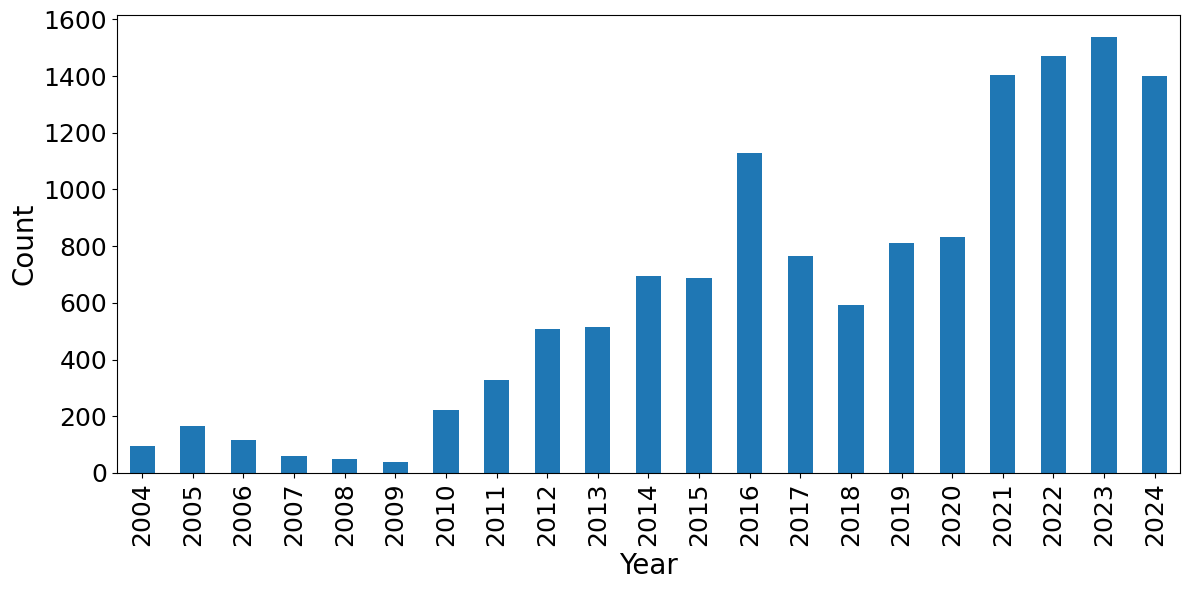

In [9]:
plt.figure(figsize=(12, 6))
df = helpers.mapping_df(floats)
df['timestamps'].groupby([df["timestamps"].dt.year]).count().plot(kind="bar")
plt.xticks(fontsize=18)   # x-axis tick labels
plt.yticks(fontsize=18)   # y-axis tick labels
plt.xlabel("Year", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tight_layout()
matplotlib.pyplot.savefig('bgcrates.png', bbox_inches='tight')
plt.show()

We quickly see that data collection by the Argo BGC array started to ramp up in earnest in 2010, and carried on through present day; let's map these profiles, then fetch and plot the dissolved oxygen as a function of pressure and time:

/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


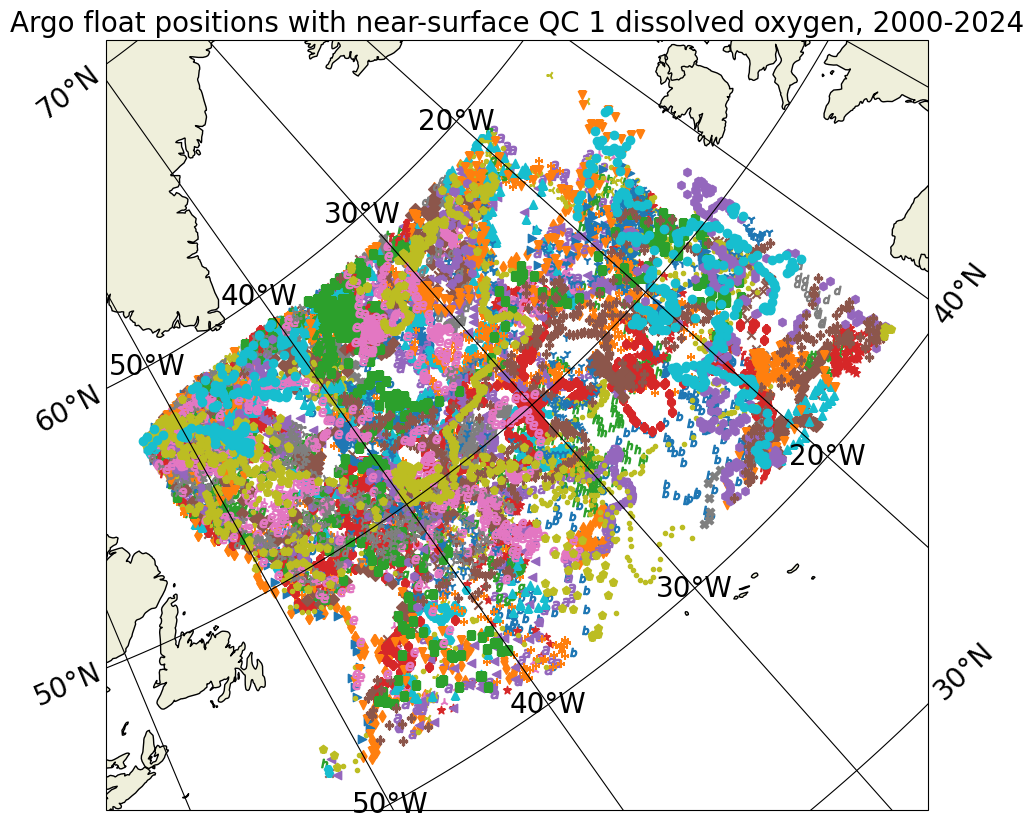

In [10]:
f = []
for x in floats:
    q = copy.deepcopy(x)
    q[3] = avh.parsetime(q[3])
    #if avh.parsetime('1010-01-01T00:00:00Z') <= q[3] and avh.parsetime('3025-01-01T00:00:00Z') > q[3]:
    f.append(q)

float_longitudes = [x[1] for x in f]
float_latitudes  = [x[2] for x in f]
float_times = [x[3] for x in f]
float_id = [x[0].split('_')[0] for x in f]

## choose markers on map categorically by float ID
id_markermap = helpers.marker_map(set(float_id))
id_markers = [id_markermap[x] for x in float_id]

helpers.simple_map(float_longitudes,float_latitudes,markers=id_markers, title='Argo float positions with near-surface QC 1 dissolved oxygen, 2000-2024')
matplotlib.pyplot.savefig('mapdoxy.png', bbox_inches='tight')

Perhaps we want to focus on a narrower region to look at full oxygen profiles:

In [11]:
#focus_region = [[-25,45],[-15,55]]
northern_doxy_params = {
    'startDate': '2010-01-01T00:00:00Z',
    'endDate': '2025-01-01T00:00:00Z',
    'center': '-35,55',
    'radius': 100,
    'data': 'doxy,1',
    'presRange': '0,2000'
}
northern_doxy = avh.query('argo', options=northern_doxy_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00Z&endDate=2025-01-01T00:00:00Z&center=-35,55&radius=100&data=doxy,1&presRange=0,2000


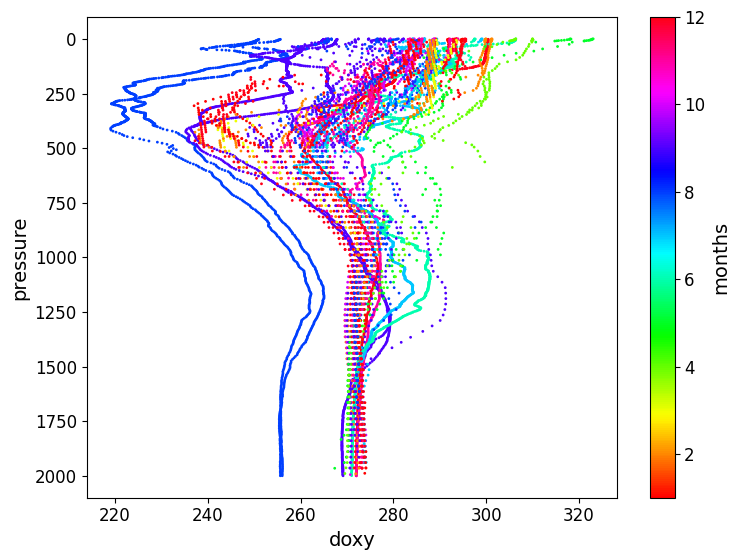

In [18]:
#northern_doxy = [x for x in northern_doxy if len(x['data'][0])>200]
df = helpers.level_df(northern_doxy, ['pressure', 'doxy', 'months'])
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    df['doxy'],
    df['pressure'],
    c=df['months'],
    cmap='hsv',
    s=1
)
ax.invert_yaxis()
ax.set_xlabel('doxy', fontsize=14)
ax.set_ylabel('pressure', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('months', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('doxyprof.png', bbox_inches='tight')
plt.show()

## Colocation, cross-referencing and discovery

One common task sought by data consumers is the ability to cross-reference one dataset with another, and colocate measurements temporospatially for cross-checks, validations and improved statistical confidence in those measurements. Argovis' semi-consistent schema and API structure makes this a straightforward task. The astute reader may note that many of the BGC profiles mapped above pass near the A25 line; let's therefore look for cruises on this line:

In [19]:
cchdo_param = {
    'woceline': 'A25'
}

cruise_meta = avh.query('cchdo/meta', options=cchdo_param, apikey=API_KEY, apiroot=API_ROOT, verbose=True)
cruises = [x['cchdo_cruise_id'] for x in cruise_meta]
cruises

https://argovis-api.colorado.edu/cchdo/meta?woceline=A25


[1072, 1144, 1144, 679, 679, 1194, 1194, 944, 2594, 82]

In [20]:
# what are the dates of these cruises?

for c in cruises:
    cchdo_param = {
        "cchdo_cruise": c,
        "compression": "minimal"
    }

    cruise_location = avh.query('cchdo', options=cchdo_param, apikey=API_KEY, apiroot=API_ROOT, verbose=True)
    dates = [avh.parsetime(x[3]) for x in cruise_location]
    print(c, min(dates), max(dates))

https://argovis-api.colorado.edu/cchdo?cchdo_cruise=1072&compression=minimal
1072 2006-05-25 05:39:00 2006-06-26 20:47:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=1144&compression=minimal
1144 2002-06-13 15:15:00 2002-07-10 22:24:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=1144&compression=minimal
1144 2002-06-13 15:15:00 2002-07-10 22:24:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=679&compression=minimal
679 2004-06-07 18:16:59 2004-07-03 17:02:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=679&compression=minimal
679 2004-06-07 18:16:59 2004-07-03 17:02:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=1194&compression=minimal
1194 2008-06-10 17:12:00 2008-07-04 20:15:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=1194&compression=minimal
1194 2008-06-10 17:12:00 2008-07-04 20:15:00
https://argovis-api.colorado.edu/cchdo?cchdo_cruise=944&compression=minimal
944 2010-06-10 19:25:59 2010-06-30 03:58:00
https://argovis-api.colorado.e

In [21]:
# cruise 944 falls in the roi and time window from the BGC study above

cruise_944_params = {
    'cchdo_cruise': 944,
    'data': 'all'
}

cruise_944 = avh.query('cchdo', options=cruise_944_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/cchdo?cchdo_cruise=944&data=all


In [22]:
colo_bgc_loose = []
for ship_meas in cruise_944:
    argo_param = {
        "center": str(ship_meas['geolocation']['coordinates'][0]) + ',' + str(ship_meas['geolocation']['coordinates'][1]),
        "radius": 10,
        "startDate": avh.parsetime((avh.parsetime(ship_meas['timestamp']) + datetime.timedelta(hours=-12))),
        "endDate": avh.parsetime((avh.parsetime(ship_meas['timestamp']) + datetime.timedelta(hours=+12))),
        "source": 'argo_bgc'
    }

    prox = avh.query('argo', options=argo_param, apikey=API_KEY, apiroot=API_ROOT, verbose=True)
    
    if len(prox) != 0:
        colo_bgc_loose = colo_bgc_loose + prox 

print('ids of BGC profiles near cruise 944 stations:', [x['_id'] for x in colo_bgc_loose])

https://argovis-api.colorado.edu/argo?center=-42.613,59.846&radius=10&startDate=2010-06-29T15:58:00.000000Z&endDate=2010-06-30T15:58:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?center=-42.702,59.86&radius=10&startDate=2010-06-29T15:05:00.000000Z&endDate=2010-06-30T15:05:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?center=-42.796,59.877&radius=10&startDate=2010-06-29T14:13:00.000000Z&endDate=2010-06-30T14:13:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?center=-42.906,59.891&radius=10&startDate=2010-06-29T13:16:00.000000Z&endDate=2010-06-30T13:16:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?center=-43.004,59.905&radius=10&startDate=2010-06-29T12:21:00.000000Z&endDate=2010-06-30T12:21:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?center=-43.074,59.913&radius=10&startDate=2010-06-29T11:33:00.000000Z&endDate=2010-06-30T11:33:00.000000Z&source=argo_bgc
https://argovis-api.colorado.edu/argo?cen

/books/special_topics/../dataset_specific_notebooks/helpers.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(polygon_lon_lat(str(polygon))['lon'],polygon_lon_lat(str(polygon))['lat'],'-k',transform=ccrs.PlateCarree(), linewidth=polygonweight, color='red')


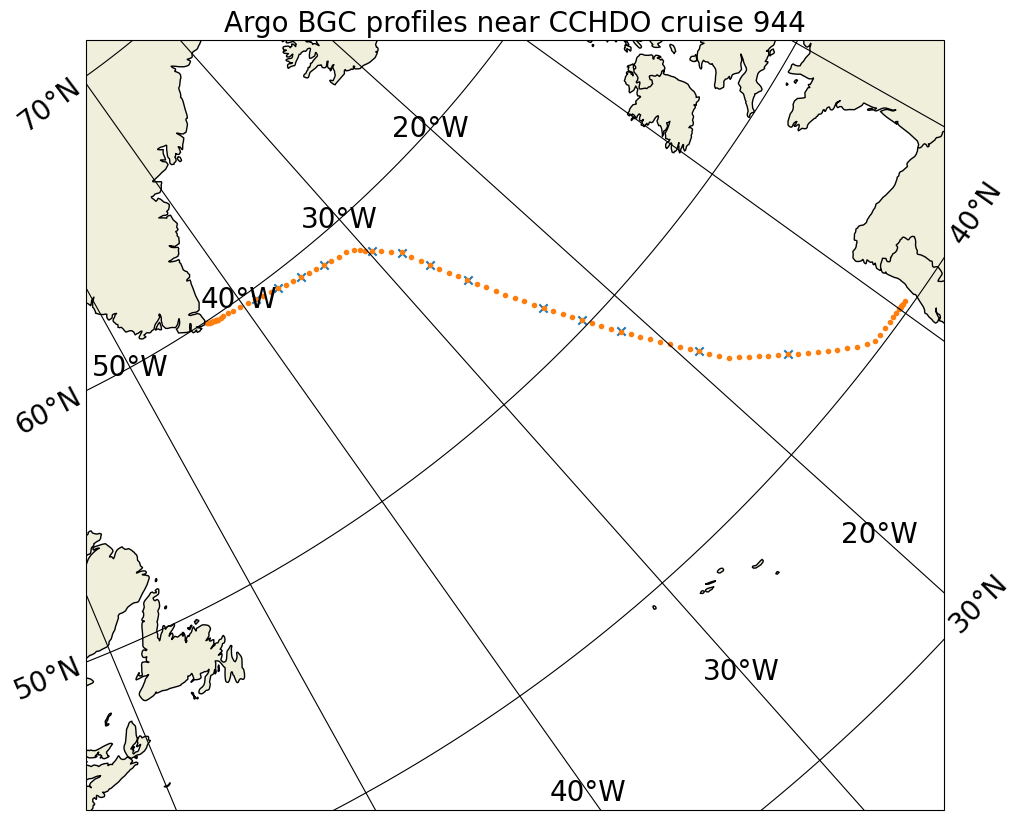

In [23]:
cruise_longitudes = [x['geolocation']['coordinates'][0] for x in cruise_944]
cruise_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise_944]
cruise_markers = ['.']*len(cruise_944)

bgc_longitudes = [x['geolocation']['coordinates'][0] for x in colo_bgc_loose]
bgc_latitudes  = [x['geolocation']['coordinates'][1] for x in colo_bgc_loose]
bgc_markers = ['x']*len(colo_bgc_loose)

longitudes = cruise_longitudes + bgc_longitudes
latitudes = cruise_latitudes + bgc_latitudes
markers = cruise_markers + bgc_markers

helpers.simple_map(longitudes,latitudes,markers=markers, polygon=region, polygonweight=0, title='Argo BGC profiles near CCHDO cruise 944')
matplotlib.pyplot.savefig('bgccolo.png', bbox_inches='tight')

## Regular interpolations

Another relatively easy task to accomplish with Argovis-formatted data is to produce data interpolated to a regular grid. Let's look at CCHDO cruise 2507, a 2020 occupancy of A05:

In [24]:
A05_params = {
    'cchdo_cruise': 2507,
    'data': 'temperature',
    'presRange': [0,1100]
}

A05 = avh.query('cchdo', options=A05_params, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/cchdo?cchdo_cruise=2507&data=temperature&presRange=0&presRange=1100


Note we're going to get pressure and temperature vectors limited to a pressure range suitable for passing directly into a scipy interpolator. Let's do a pchip interpolation of temperature to levels in intervals of 5 decibar, from 10 to 1000 decibar:

In [25]:
levels = list(range(0,1000,5))
def interpolate_profile(raw, variable, levels):
    # raw: a single argovis profile as returned from the API, including a data_info key
    # variable: anything found in data_info[0] in the provided profile; the variable to interpolate
    # levels: the standard levels to interp to.
    
    # extract pressure and the variable to interpolate
    var_idx = raw['data_info'][0].index(variable)
    pressure_idx = raw['data_info'][0].index('pressure')
    var = raw['data'][var_idx]
    pressure = raw['data'][pressure_idx]
    
    # don't evaluate the interpolation outside the range of available pressures
    lvl = [x if x>pressure[0] and x<pressure[-1] else numpy.NAN for x in levels]
    
    return list(scipy.interpolate.pchip_interpolate(pressure, var, lvl))

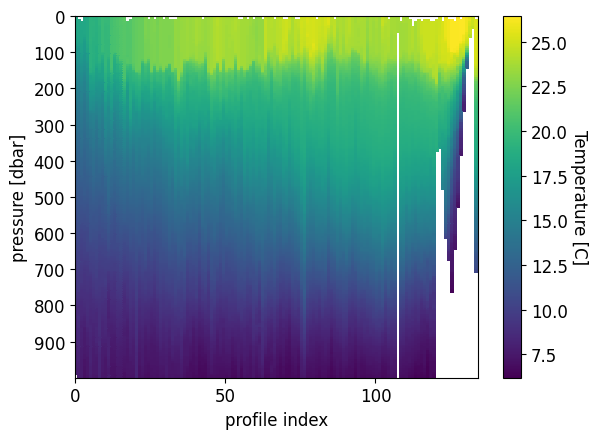

In [31]:
temp_interp = [ interpolate_profile(x, 'temperature', levels) for x in A05 ]
temp_interp = numpy.array(temp_interp).T
columns = [x['_id'][18:33] for x in A05]
df = pandas.DataFrame(temp_interp, index=levels, columns=columns)
plt.pcolor(df)
tickidx = numpy.arange(0, len(df.index), 20)
plt.yticks(tickidx, [df.index[x] for x in tickidx], fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('pressure [dbar]', fontsize=12)
plt.xlabel('profile index', fontsize=12)
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_label('Temperature [C]', rotation=270, labelpad=15, fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('interptemp.png', bbox_inches='tight', dpi=300)
plt.show()

## Fleet-level summaries

Another interesting class of data reduction problem are large scale summaries: analyzing and visualizing summary data for the entire globe, or the entire history of a program like Argo. Let's begin similarly to above, by mapping all the Argo BGC profiles from 2020 that have QC 1 dissolved oxygen:

In [32]:
datafilter = {
    'startDate': '2020-01-01T00:00:00Z',
    'endDate': '2021-01-01T00:00:00Z',
    'data': 'doxy,1',
    'presRange': [100,150],
    'compression': 'minimal'
}

doxy = avh.query('argo', options=datafilter, apikey=API_KEY, apiroot=API_ROOT, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2020-01-01T00:00:00Z&endDate=2021-01-01T00:00:00Z&data=doxy,1&presRange=100&presRange=150&compression=minimal


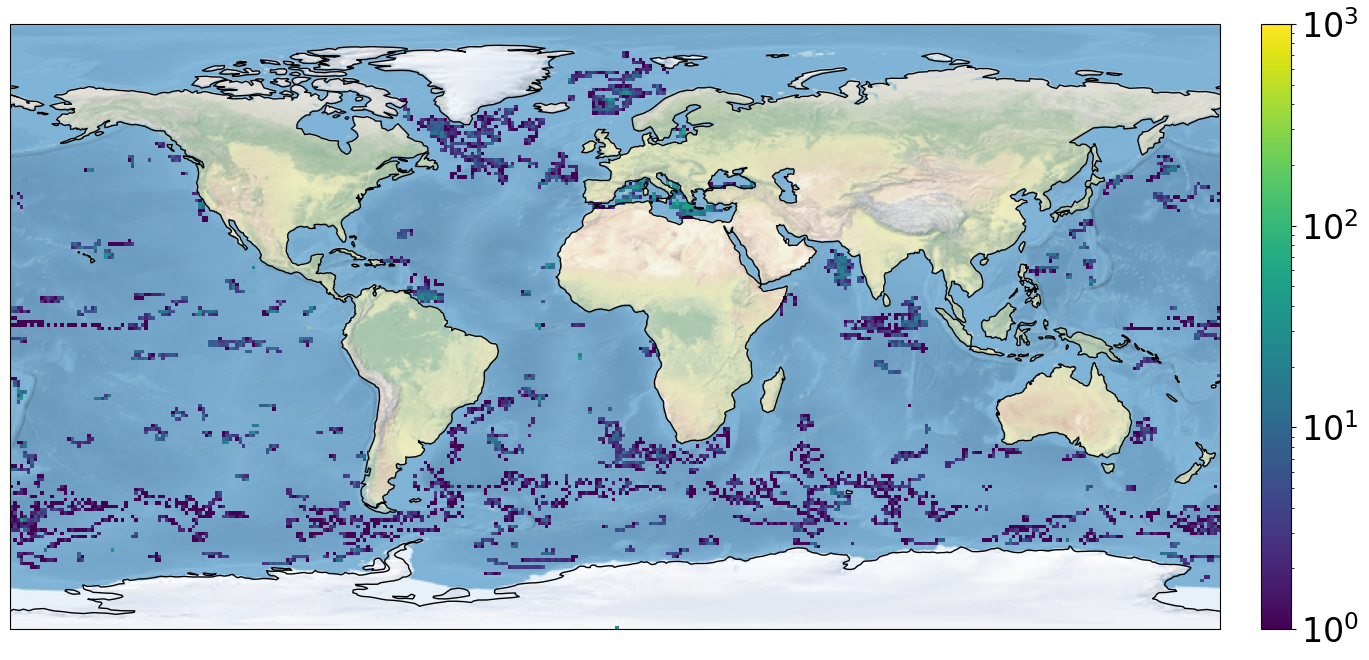

In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs
import numpy as np

def map_count_in_bins(df, startDate, endDate, outname='doxymap',
                      x_bound=[-180,181], y_bound=[-90,91], dx=1, dy=1,
                      fpath='./', vmin_map=1, vmax_map=1000):

    x_edges = np.arange(x_bound[0], x_bound[1], dx)
    y_edges = np.arange(y_bound[0], y_bound[1], dy)

    lons = df['longitudes']
    lats = df['latitudes']

    fig = plt.figure(figsize=(21, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())

    h, _, _ = np.histogram2d(lons, lats, bins=[x_edges, y_edges])

    mesh = ax.pcolormesh(
        x_edges[:-1] + dx / 2,
        y_edges[:-1] + dy / 2,
        h.T,
        transform=ccrs.PlateCarree(),
        norm=matplotlib.colors.LogNorm(vmin=vmin_map, vmax=vmax_map),
        cmap='viridis'
    )

    ax.stock_img()
    ax.coastlines()

    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', ticks=[1, 10, 100, 1000], pad=0.02)
    cbar.ax.tick_params(labelsize=24)

    plt.tight_layout()
    outfile = f'{fpath}{outname}.png'
    plt.savefig(outfile, bbox_inches='tight', dpi=150)
    plt.show()
    
df = helpers.mapping_df(doxy)
map_count_in_bins(df,datafilter['startDate'],datafilter['endDate'])

We can also make timeseries representations of metadata relatively easily. For example, let's make a timeseries of Argo program profiles (core versus BGC versus deep) in use by the Argo array:

In [45]:
# this section takes some time.

In [4]:
argo_profile_params = {
    'startDate': '2000-01-01T00:00:00Z',
    'endDate': '2025-01-01T00:00:00Z',
    'compression': 'minimal'
}

argo_profiles = avh.query('argo', options=argo_profile_params, apikey=API_KEY, apiroot=API_ROOT, slice=True, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2000-01-01T00:00:00.000000Z&endDate=2000-03-13T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2000-03-13T00:00:00.000000Z&endDate=2000-05-24T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2000-05-24T00:00:00.000000Z&endDate=2000-08-04T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2000-08-04T00:00:00.000000Z&endDate=2000-10-15T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2000-10-15T00:00:00.000000Z&endDate=2000-12-26T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2000-12-26T00:00:00.000000Z&endDate=2001-03-08T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2001-03-08T00:00:00.000000Z&endDate=2001-05-19T00:00:00.000000Z&compression=minimal
https://argovis-api.colorado.edu/argo?startDate=2001-05-19T00:00:00.000000Z&

In [5]:
def categorize_argo(source):
    if 'argo_core' in source and not 'argo_bgc' in source and not 'argo_deep' in source:
        return 'core'
    elif 'argo_bgc' in source and not 'argo_deep' in source:
        return 'bgc'
    elif 'argo_deep' in source and not 'argo_bgc' in source:
        return 'deep'
    elif 'argo_bgc' in source and 'argo_deep' in source:
        return 'deep_bgc'

ts_core = [ [avh.parsetime(x[3]), 'core' ] for x in argo_profiles if 'argo_core' in x[4] and not 'argo_deep' in x[4]]
ts_bgc = [ [avh.parsetime(x[3]), 'bgc' ] for x in argo_profiles if 'argo_bgc' in x[4] and not 'argo_deep' in x[4]]
ts_deep = [ [avh.parsetime(x[3]), 'deep' ] for x in argo_profiles if 'argo_deep' in x[4] and not 'argo_bgc' in x[4]]
ts_bgcdeep = [ [avh.parsetime(x[3]), 'deep_bgc' ] for x in argo_profiles if 'argo_bgc' in x[4] and 'argo_deep' in x[4]]
    
ts = ts_core + ts_bgc + ts_deep + ts_bgcdeep
df = pandas.DataFrame(ts, columns=['timestamps', 'source'])

In [6]:
def categorical_df(df, startYear, endYear, category):
    timebounds = []
    for y in range(startYear, endYear+2):
        timebounds.append(avh.parsetime(f'{y}-01-01T00:00:00Z'))
    catdf = pandas.crosstab(pandas.cut(df['timestamps'],timebounds), df[category])
    catdf.index = catdf.index.rename_categories(range(startYear,endYear+1))
    
    return catdf

In [7]:
catdf = categorical_df(df,2000,2025,'source')

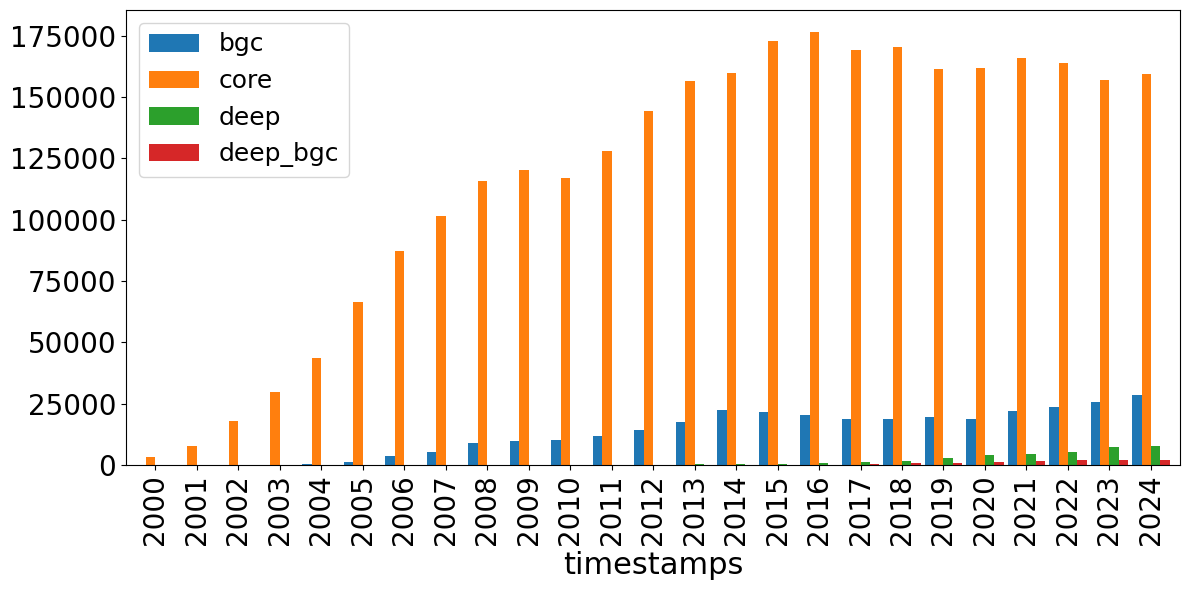

In [14]:
ax = catdf.plot.bar(
    figsize=(12, 6),
    width=0.9,          # thicker bars (default is 0.8)
    fontsize=20         # larger tick label font
)

ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)
ax.set_title(ax.get_title(), fontsize=24)
ax.legend(fontsize=18)

plt.tight_layout()
plt.savefig('mission.png', bbox_inches='tight', dpi=150)
plt.show()

We can similarly construct a timeseries of metadata categories from metadata found on the metadata docs. Here the convenience switch `batchmeta` comes in handy; the query below will return all the metadata docs corresponding to the data documents returned without the `batchmeta` flag set:

In [15]:
argo_2010_fleet_metaops = {
    'startDate': '2010-01-01T00:00:00Z',
    'endDate': '2020-01-01T00:00:00Z',
    'batchmeta': 'true'
}

argo2010meta = avh.query('argo', options=argo_2010_fleet_metaops, apikey=API_KEY, apiroot=API_ROOT, slice=True, verbose=True)

https://argovis-api.colorado.edu/argo?startDate=2010-01-01T00:00:00.000000Z&endDate=2010-03-14T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-03-14T00:00:00.000000Z&endDate=2010-05-25T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-05-25T00:00:00.000000Z&endDate=2010-08-05T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-08-05T00:00:00.000000Z&endDate=2010-10-16T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-10-16T00:00:00.000000Z&endDate=2010-12-27T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2010-12-27T00:00:00.000000Z&endDate=2011-03-09T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2011-03-09T00:00:00.000000Z&endDate=2011-05-20T00:00:00.000000Z&batchmeta=true
https://argovis-api.colorado.edu/argo?startDate=2011-05-20T00:00:00.000000Z&endDate=2011-07-31T00:00:00.000000Z

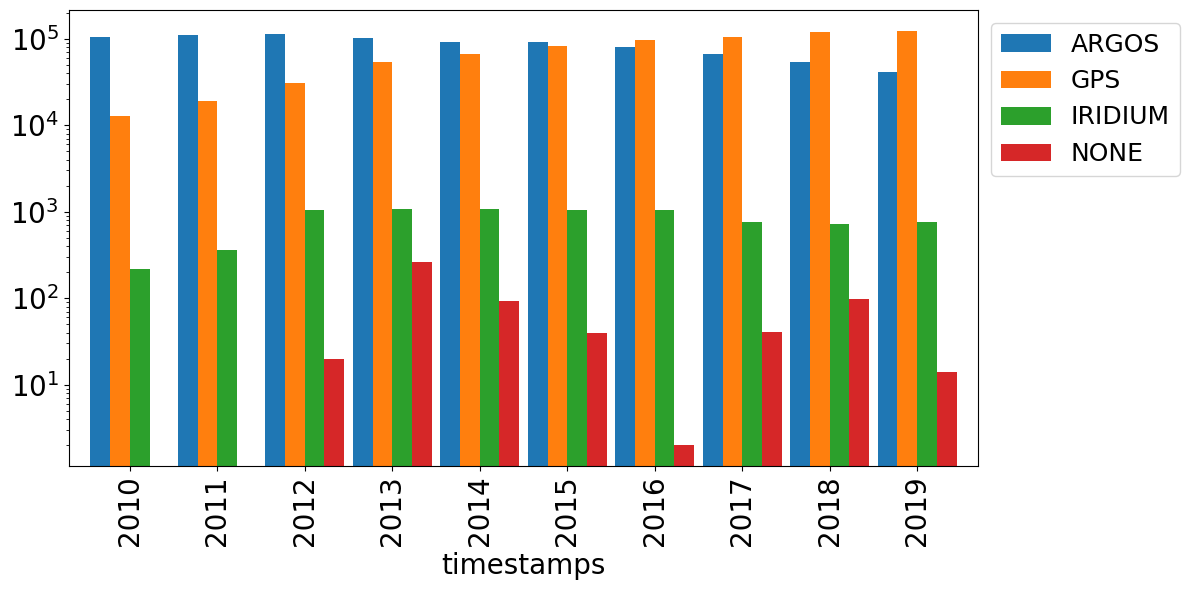

In [20]:
metalookup = {x['_id']: x for x in argo2010meta}
ts = [ [avh.parsetime(x[3]), metalookup[x[5][0]]['positioning_system'] ] for x in argo_profiles if 2010 <= avh.parsetime(x[3]).year <= 2019]
del metalookup
df = pandas.DataFrame(ts, columns=['timestamps', 'positioning_system'])
del ts
catdf = categorical_df(df,2010,2020,'positioning_system')
#catdf.plot.bar(logy=True).legend(bbox_to_anchor=(1.0, 1.0))
ax = catdf.plot.bar(
    logy=True,
    figsize=(12, 6),
    width=0.9,
    fontsize=20  # tick label font size
)

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.set_title(ax.get_title(), fontsize=22)
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=18)

plt.tight_layout()
plt.savefig('positioning_systems.png', bbox_inches='tight', dpi=150)
plt.show()